In [4]:
##Ridge regression 

import os
import matplotlib.pyplot as plt
import numpy as np
import scripts.implementations as lib  # Add personal library
import scripts.proj1_helpers as helper  # Add personal library

%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4)

DATA_FOLDER = 'data'
DATA_TRAIN = os.path.join(DATA_FOLDER, 'train.csv')
DATA_TEST = os.path.join(DATA_FOLDER, 'test.csv')

y, x, ids, header = helper.load_csv_data(DATA_TRAIN)
y_train, x_train,  y_validation, x_validation = lib.sep_valid_train_data(x,y, 0.8);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
x_train[x_train == -999] = np.nan
x_validation[x_validation == -999] = np.nan

In [6]:
for i, feature in enumerate(x_train.T):
    print('Feature {} - {} has range: [{:.4f}, {:.4f}]'.format(
        i+1, header[i], np.nanmin(feature), np.nanmax(feature)))

Feature 1 - DER_mass_MMC has range: [9.0440, 1192.0260]
Feature 2 - DER_mass_transverse_met_lep has range: [0.0000, 595.8190]
Feature 3 - DER_mass_vis has range: [6.4620, 1329.9130]
Feature 4 - DER_pt_h has range: [0.0000, 1053.8070]
Feature 5 - DER_deltaeta_jet_jet has range: [0.0000, 8.5030]
Feature 6 - DER_mass_jet_jet has range: [13.6020, 4974.9790]
Feature 7 - DER_prodeta_jet_jet has range: [-18.0660, 16.6900]
Feature 8 - DER_deltar_tau_lep has range: [0.2080, 5.6840]
Feature 9 - DER_pt_tot has range: [0.0000, 513.6590]
Feature 10 - DER_sum_pt has range: [46.1040, 1852.4620]
Feature 11 - DER_pt_ratio_lep_tau has range: [0.0470, 19.7730]
Feature 12 - DER_met_phi_centrality has range: [-1.4140, 1.4140]
Feature 13 - DER_lep_eta_centrality has range: [0.0000, 1.0000]
Feature 14 - PRI_tau_pt has range: [20.0000, 622.8620]
Feature 15 - PRI_tau_eta has range: [-2.4990, 2.4970]
Feature 16 - PRI_tau_phi has range: [-3.1420, 3.1420]
Feature 17 - PRI_lep_pt has range: [26.0000, 461.8960]
Fea

In [15]:
def plot_train_test(train_errors, test_errors, lambdas, degree):
    """
    train_errors, test_errors and lambas should be list (of the same size) the respective train error and test error for a given lambda,
    * lambda[0] = 1
    * train_errors[0] = RMSE of a ridge regression on the train set
    * test_errors[0] = RMSE of the parameter found by ridge regression applied on the test set
    
    degree is just used for the title of the plot.
    """
    plt.semilogx(lambdas, train_errors, color='b', marker='*', label="Train error")
    plt.semilogx(lambdas, test_errors, color='r', marker='*', label="Test error")
    plt.xlabel("lambda")
    plt.ylabel("RMSE")
    plt.title("Ridge regression for polynomial degree " + str(degree))
    leg = plt.legend(loc=1, shadow=True)
    leg.draw_frame(False)
    plt.savefig("ridge_regression")
    
def test_ridge_regression(x, y, x_val, y_val, degrees, lambdas):
    
    best_acc = 0
    best_degree = 0
    best_lambda = 0
    best_rmse_tr = []
    best_rmse_te = []
    best_weights = []
    for degree in degrees:
        degree = int(degree)
        #lambdas = np.logspace(-7, 2, 20)

        # Split sets
        #x_train, x_test, y_train, y_test = split_data(x, y, ratio, seed)

        # Get ploynomial
        phi_train = lib.build_poly(x, degree)
        phi_test = lib.build_poly(x_val, degree)

        rmse_tr = []
        rmse_te = []
        update_rmse = False

        for ind, lambda_ in enumerate(lambdas):

            mse_tr, weights = lib.ridge_regression(y, phi_train, lambda_)
            mse_te = lib.compute_loss(y_val, phi_test.dot(weights))
            rmse_tr.append(np.sqrt(2*mse_tr))
            rmse_te.append(np.sqrt(2*mse_te))

            print("degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                    d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
            print('train acc : ', lib.accuracy(y, phi_train.dot(weights)))
            val_acc = lib.accuracy(y_val, phi_test.dot(weights))
            print('validation acc : ', val_acc)

            if(val_acc > best_acc):
                best_acc = val_acc
                best_degree = degree
                best_lambda = lambda_
                best_weights = weights
                update_rmse = True
        
        if(update_rmse):
            best_rmse_tr = rmse_tr
            best_rmse_te = rmse_te

        # Plot the best obtained results
    plot_train_test(best_rmse_tr, best_rmse_te, lambdas, best_degree)

    print('Best params for Ridge regression : degree = ',best_degree, ', lambda = ',best_lambda,', accuracy = ', best_acc)
    
    return best_weights, best_degree, best_lambda

In [48]:
from scripts.ml import augmented_feat_angle

id_angle_feat = np.array([15, 18, 20, 25, 28])
id_left = [ i for i in range(x_train.shape[1]) if i not in id_angle_feat]

# Augment features
x_aug = augmented_feat_angle(x_train, id_angle_feat)
x_aug = np.concatenate((x_train[:, id_left], x_aug), axis=1)
x_aug_val = augmented_feat_angle(x_validation, id_angle_feat)
x_aug_val = np.concatenate((x_validation[:, id_left], x_aug_val), axis=1)
print('Shape:', x_aug.shape)

# normalize features
x_no_nan = x_aug.copy()
x_no_nan = (x_no_nan - np.nanmean(x_no_nan, axis=0)) # /np.nanstd(x_no_nan, axis=0)
x_no_nan = np.nan_to_num(x_no_nan)
x_no_nan /= np.nanstd(x_no_nan, axis=0)
print('\nStd:', np.std(x_no_nan, axis=0))

# normalize features
x_no_nan_val = x_aug_val.copy()
x_no_nan_val = (x_no_nan_val - np.nanmean(x_no_nan_val, axis=0)) #/np.nanstd(x_no_nan_val, axis=0)
x_no_nan_val = np.nan_to_num(x_no_nan_val)
x_no_nan_val /= np.nanstd(x_no_nan_val, axis=0)

print('\nStd:', np.std(x_no_nan_val, axis=0))

Shape: (200000, 35)

Std: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]

Std: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


degree=9, lambda=0.000, Training RMSE=0.745, Testing RMSE=51572439.979
train acc :  0.815455
validation acc :  0.48628
degree=9, lambda=0.000, Training RMSE=0.745, Testing RMSE=51572834.409
train acc :  0.815405
validation acc :  0.52002
degree=9, lambda=0.000, Training RMSE=0.745, Testing RMSE=51573952.782
train acc :  0.81539
validation acc :  0.58068
degree=9, lambda=0.000, Training RMSE=0.745, Testing RMSE=51577021.539
train acc :  0.81543
validation acc :  0.6405
degree=9, lambda=0.000, Training RMSE=0.745, Testing RMSE=51584743.166
train acc :  0.815405
validation acc :  0.8096
degree=9, lambda=0.000, Training RMSE=0.745, Testing RMSE=51600068.689
train acc :  0.815435
validation acc :  0.81344
degree=9, lambda=0.000, Training RMSE=0.745, Testing RMSE=51616941.205
train acc :  0.81542
validation acc :  0.81512
degree=9, lambda=0.000, Training RMSE=0.745, Testing RMSE=51613923.388
train acc :  0.815365
validation acc :  0.81486
degree=9, lambda=0.000, Training RMSE=0.745, Testing 

degree=10, lambda=0.838, Training RMSE=0.976, Testing RMSE=19608363.586
train acc :  0.694495
validation acc :  0.69976
degree=10, lambda=1.425, Training RMSE=0.983, Testing RMSE=244767.886
train acc :  0.69177
validation acc :  0.69766
degree=10, lambda=2.424, Training RMSE=0.987, Testing RMSE=18864003.383
train acc :  0.690055
validation acc :  0.69538
degree=10, lambda=4.125, Training RMSE=0.989, Testing RMSE=29933381.008
train acc :  0.688115
validation acc :  0.69406
degree=10, lambda=7.017, Training RMSE=0.991, Testing RMSE=33485561.374
train acc :  0.68561
validation acc :  0.69176
degree=10, lambda=11.938, Training RMSE=0.993, Testing RMSE=29614450.492
train acc :  0.6835
validation acc :  0.68836
degree=10, lambda=20.309, Training RMSE=0.994, Testing RMSE=20039625.535
train acc :  0.682385
validation acc :  0.68778
degree=10, lambda=34.551, Training RMSE=0.995, Testing RMSE=9054941.498
train acc :  0.683455
validation acc :  0.689
degree=10, lambda=58.780, Training RMSE=0.996,

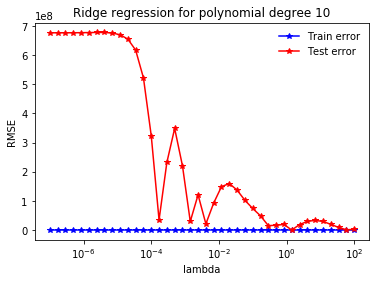

In [49]:
weights_no_nan, degree_no_nan, lambda_no_nan = test_ridge_regression(
    x_no_nan, y_train, x_no_nan_val, y_validation, 
    degrees = np.linspace(9,11,3), lambdas=np.logspace(-7,2,40))

In [54]:
from scripts.ml import build_poly, least_squares

# Build polynomial matrix
_phi_train = build_poly(x_naive, 3)
loss_tr, weights = least_squares(y_train, _phi_train)

In [68]:
weights[0:len(header)]
w = weights[1:].reshape((-1, x_naive.shape[1]))
print(np.sum(np.max(np.abs(w), axis=0) > 0.1))

10


In [69]:
feat_keep = np.max(np.abs(w), axis=0) > 0.1
head_naive[feat_keep]

array(['DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h',
       'DER_deltar_tau_lep', 'DER_sum_pt', 'DER_pt_ratio_lep_tau',
       'PRI_tau_pt', 'PRI_lep_pt', 'PRI_jet_num', 'PRI_jet_all_pt'],
      dtype='<U27')

In [70]:
from scripts.ml import build_poly, least_squares

degrees = np.linspace(1, 6, 6).astype(int)
for i, degree in enumerate(degrees):
    acc, _, _ = cross_validation_ls(y_train, x_naive[:, feat_keep], degree=degree)
    print('{}/{} Least square deg {} with acc {:.4f}'.format(i+1, len(degrees), degree, acc))

1/6 Least square deg 1 with acc 0.7355
2/6 Least square deg 2 with acc 0.7479
3/6 Least square deg 3 with acc 0.7544
4/6 Least square deg 4 with acc 0.7534
5/6 Least square deg 5 with acc 0.7553
6/6 Least square deg 6 with acc 0.7295


In [90]:
from scripts.ml import augmented_feat_angle

id_angle_feat = np.array([10, 13, 15])
x_aug = augmented_feat_angle(x_naive, id_angle_feat)

x_naive_aug = np.concatenate((x_naive[:, feat_keep], x_aug), axis=1)


# normalize features
#x_aug = (x_aug - np.nanmean(x_aug, axis=0))/np.nanstd(x_aug, axis=0)
#x_aug = np.nan_to_num(x_aug)
#print('\nStd:', np.std(x_aug, axis=0))

#print(np.max(x_train[:, 15]))

x_naive_aug = (x_naive_aug - np.mean(x_naive_aug, axis=0))/np.std(x_naive_aug, axis=0)


degrees = np.linspace(1, 6, 6).astype(int)
for i, degree in enumerate(degrees):
    acc, _, _ = cross_validation_ls(y_train, x_naive_aug, degree=degree)
    print('{}/{} Least square deg {} with acc {:.4f}'.format(i+1, len(degrees), degree, acc))

1/6 Least square deg 1 with acc 0.7357
2/6 Least square deg 2 with acc 0.6631
3/6 Least square deg 3 with acc 0.6215
4/6 Least square deg 4 with acc 0.5946
5/6 Least square deg 5 with acc 0.6269
6/6 Least square deg 6 with acc 0.5415


In [77]:
print(head_naive[[10, 13, 15]])

['PRI_tau_phi' 'PRI_lep_phi' 'PRI_met_phi']
